# Summary

本次 HW5 作業的要求是在不使用 PyTorch 及 TensorFlow 等深度學習框架的前提下，使用 Numpy/Cupy 從零開始建構一個循環神經網路 (Recurrent Neural Network, RNN)，並用其來分類 MNIST 資料集。作業的核心挑戰在於手動實作隨時間反向傳播 (BPTT) 演算法，並將通常用於序列資料的 RNN 模型，創新地應用於處理圖片（像素列的序列）。

我在實作過程中遇到了梯度消失 (Vanishing Gradients) 導致模型訓練停滯的問題，透過改用 Xavier 權重初始化方法成功解決，這也加深了我對神經網路訓練穩定性的理解。

最終，在 MNIST 資料集上，模型達到了 97.72% 的高準確率。我同時也完成了各項性能計算（精確率、召回率）、繪製混淆矩陣與學習曲線，並加入了提早停止 (Early Stopping) 機制來防止過擬合。

作為加分挑戰，我也將此 RNN 模型應用於更複雜的 CIFAR-10 彩色圖片資料集。在這個更具挑戰性的任務上，模型取得了 52.79% 的準確率，並同樣完成了相關的性能評估。

其餘詳細的性能分析、與 CNN 模型的比較，以及本次作業的心得，在檔案最後 Conclusion 的部分有詳盡的闡述。

# Step 0: 環境設定

In [1]:
import numpy as np
import time
import copy
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: 下載並預處理資料

## Step 1-1: 下載 MNIST

（延用 HW3 和 HW4 的程式）

In [2]:
# 延用 HW3 和 HW4 中下載 mnist 的程式
def get_mnist():
    """
    The code to download the mnist data original came from
    https://cntk.ai/pythondocs/CNTK_103A_MNIST_DataLoader.html
    """

    import gzip
    import numpy as np
    import os
    import struct

    from urllib.request import urlretrieve

    def load_data(src, num_samples):
        print("Downloading " + src)
        gzfname, h = urlretrieve(src, "./delete.me")
        print("Done.")
        try:
            with gzip.open(gzfname) as gz:
                n = struct.unpack("I", gz.read(4))
                # Read magic number.
                if n[0] != 0x3080000:
                    raise Exception("Invalid file: unexpected magic number.")
                # Read number of entries.
                n = struct.unpack(">I", gz.read(4))[0]
                if n != num_samples:
                    raise Exception(f"Invalid file: expected {num_samples} entries.")
                crow = struct.unpack(">I", gz.read(4))[0]
                ccol = struct.unpack(">I", gz.read(4))[0]
                if crow != 28 or ccol != 28:
                    raise Exception("Invalid file: expected 28 rows/cols per image.")
                # Read data.
                res = np.frombuffer(gz.read(num_samples * crow * ccol), dtype=np.uint8)
        finally:
            os.remove(gzfname)
        # 這次我們不在這裡做 normalize，留到 CuPy 陣列處理
        return res.reshape((num_samples, crow, ccol))

    def load_labels(src, num_samples):
        print("Downloading " + src)
        gzfname, h = urlretrieve(src, "./delete.me")
        print("Done.")
        try:
            with gzip.open(gzfname) as gz:
                n = struct.unpack("I", gz.read(4))
                # Read magic number.
                if n[0] != 0x1080000:
                    raise Exception("Invalid file: unexpected magic number.")
                # Read number of entries.
                n = struct.unpack(">I", gz.read(4))
                if n[0] != num_samples:
                    raise Exception(f"Invalid file: expected {num_samples} rows.")
                # Read labels.
                res = np.frombuffer(gz.read(num_samples), dtype=np.uint8)
        finally:
            os.remove(gzfname)
        return res.reshape(num_samples)

    def try_download(data_source, label_source, num_samples):
        data = load_data(data_source, num_samples)
        labels = load_labels(label_source, num_samples)
        return data, labels

    server = "https://raw.githubusercontent.com/fgnt/mnist/master"

    # URLs for the train image and label data
    url_train_image = f"{server}/train-images-idx3-ubyte.gz"
    url_train_labels = f"{server}/train-labels-idx1-ubyte.gz"
    num_train_samples = 60000

    print("Downloading train data")
    train_features, train_labels = try_download(url_train_image, url_train_labels, num_train_samples)

    # URLs for the test image and label data
    url_test_image = f"{server}/t10k-images-idx3-ubyte.gz"
    url_test_labels = f"{server}/t10k-labels-idx1-ubyte.gz"
    num_test_samples = 10000

    print("Downloading test data")
    test_features, test_labels = try_download(url_test_image, url_test_labels, num_test_samples)

    return train_features, train_labels, test_features, test_labels

In [3]:
train_features_np, train_labels_np, test_features_np, test_labels_np = get_mnist()

Done.
Done.
Done.
Done.


## Step 1-2: Reshape and Normalize

In [4]:
# 這次我們不需要像 CNN 那樣增加一個 channel 維度
# shape 本身 (num_samples, 28, 28) 就已經符合 RNN (num_samples, timesteps, features) 的要求

# 引入 Cupy
import cupy as cp

# 使用 cp.asarray() 將所有資料從 CPU memory 移至 GPU memory
train_x_cp = cp.asarray(train_features_np)
train_y_cp_orig = cp.asarray(train_labels_np)
test_x_cp = cp.asarray(test_features_np)
test_y_cp_orig = cp.asarray(test_labels_np)

# --- 資料正規化 (在 Cupy 陣列上進行) ---
# 將像素值從 0-255 正規化到 0-1 之間
train_x = train_x_cp / 255.0
test_x = test_x_cp / 255.0

## Step 1-3: 對 Label 進行 One-Hot Encode

這一步和上次作業完全相同，我們要將數字標籤 (如 5) 轉換成向量 `[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]`，方便後續用 Cross-Entropy 計算損失。

In [5]:
# --- 對 Label 進行 One-Hot Encode ---
def one_hot_encode(labels, num_classes):
    one_hot = cp.zeros((labels.size, num_classes))
    one_hot[cp.arange(labels.size), labels] = 1
    return one_hot

In [6]:
# 我們的類別是數字 0-9，所以有 10 個類別
num_classes = 10
train_y = one_hot_encode(train_y_cp_orig, num_classes)
test_y = one_hot_encode(test_y_cp_orig, num_classes)


# --- 驗證一下 shape 和 type ---
print("--- Shapes and Types of CuPy arrays for RNN ---")
print("train_x.shape:", train_x.shape)
print("train_y.shape:", train_y.shape)
print("type of train_x:", type(train_x))
print("type of train_y:", type(train_y))

--- Shapes and Types of CuPy arrays for RNN ---
train_x.shape: (60000, 28, 28)
train_y.shape: (60000, 10)
type of train_x: <class 'cupy.ndarray'>
type of train_y: <class 'cupy.ndarray'>


# Step 2: 實作 RNN

## Step 2-1: 初始化權重

初始化 RNN 的權重與偏置

參數:

- `n_x` -- 輸入層的特徵維度 (在 MNIST 中是 28)
- `n_a` -- 隱藏層的神經元數量 (一個超參數，我們先設為 128)
- `n_y` -- 輸出層的類別數量 (在 MNIST 中是 10)

Return:

- `parameters` -- 一個包含所有權重與 bias 的 Python dict

In [7]:
def initialize_parameters_rnn(n_x, n_a, n_y):
    cp.random.seed(42)

    # 使用 np.random.randn 創建常態分佈的隨機權重，並乘以 0.01 讓初始權重較小
    W_ax = cp.random.randn(n_a, n_x) * cp.sqrt(1/n_x)
    W_aa = cp.random.randn(n_a, n_a) * cp.sqrt(1/n_a)
    W_ya = cp.random.randn(n_y, n_a) * cp.sqrt(1/n_a)

    # 初始化偏置為 0
    b_a = cp.zeros((n_a, 1))
    b_y = cp.zeros((n_y, 1))

    parameters = {
        "W_ax": W_ax,
        "W_aa": W_aa,
        "W_ya": W_ya,
        "b_a": b_a,
        "b_y": b_y
    }

    return parameters

In [8]:
# 設定 RNN 的維度
n_x = 28    # 每個時間步的輸入特徵數 (一張圖片的一列有 28 個像素)
n_a = 128    # 隱藏層的神經元數 (可以調整的超參數)
n_y = 10    # 輸出層的類別數

# 初始化參數並檢查維度
parameters = initialize_parameters_rnn(n_x, n_a, n_y)

print("--- Parameter Shapes ---")
print("W_ax Shape: " + str(parameters["W_ax"].shape))
print("W_aa Shape: " + str(parameters["W_aa"].shape))
print("W_ya Shape: " + str(parameters["W_ya"].shape))
print("b_a Shape:  " + str(parameters["b_a"].shape))
print("b_y Shape:  " + str(parameters["b_y"].shape))

--- Parameter Shapes ---
W_ax Shape: (128, 28)
W_aa Shape: (128, 128)
W_ya Shape: (10, 128)
b_a Shape:  (128, 1)
b_y Shape:  (10, 1)


## Step 2-2: 實作前向傳播

實作單一時間步的 RNN Cell 前向傳播

參數:

- `xt` -- 在時間點 t 的輸入資料, shape (m, n_x)，m 是批次大小
- `a_prev` -- 在時間點 t-1 的隱藏狀態, shape (m, n_a)
- `parameters` -- 包含權重的字典

Return:

- `a_next` -- 下一個隱藏狀態, shape (m, n_a)
- `cache` -- 用於反向傳播的快取，包含 (a_next, a_prev, xt, parameters)

In [9]:
def rnn_cell_forward(xt, a_prev, parameters):
    # 從字典中取出權重
    W_aa = parameters['W_aa']
    W_ax = parameters['W_ax']
    b_a = parameters['b_a']

    # 計算下一個隱藏狀態
    # 這裡的矩陣乘法 @ 和 bias的加法，Numpy 會透過廣播 (Broadcasting) 機制自動處理 batch
    # (m, n_a) = (m, n_a) @ (n_a, n_a).T + (m, n_x) @ (n_x, n_a).T + (1, n_a)
    a_next = cp.tanh(cp.dot(a_prev, W_aa.T) + cp.dot(xt, W_ax.T) + b_a.T)

    # 儲存反向傳播所需的數值
    cache = (a_next, a_prev, xt, parameters)

    return a_next, cache

### Step 2-2-2: 完整序列前向傳播

計算 Softmax

參數:

- `z` -- 輸出層的線性輸出, shape (m, n_y)

Return:

- `y_pred` -- Softmax 激活後的機率, shape (m, n_y)

In [10]:
def softmax(z):
    # 為了數值穩定性，先減去 z 中的最大值
    e_z = cp.exp(z - cp.max(z, axis=1, keepdims=True))
    return e_z / cp.sum(e_z, axis=1, keepdims=True)

實作完整 RNN 的前向傳播

參數:

- `x` -- 輸入的資料序列, shape (m, T_x, n_x) -> (批次大小, 時間步長, 特徵維度)
- `a0` -- 初始的隱藏狀態, shape (m, n_a)
- `parameters` -- 包含權重的字典

Return:

- `y_pred` -- 最終的預測機率, shape (m, n_y)
- `caches` -- 包含所有時間步快取的列表，用於反向傳播

In [11]:
def rnn_forward(x, a0, parameters):
    # 初始化一個列表來儲存所有 RNN Cell 的快取
    caches = []

    # 從 x 的維度取得樣本數 m 和 timestep T_x
    m, T_x, n_x = x.shape

    # 從權重的維度取得 n_y 和 n_a
    n_y, n_a = parameters['W_ya'].shape

    # 初始化一個陣列來儲存所有 timestep 的隱藏狀態
    a = cp.zeros((m, T_x, n_a))

    # 將 a_next 初始化為 a0
    a_next = a0

    # 遍歷所有 timestep
    for t in range(T_x):
        # 取得當前 step 的輸入 xt, shape (m, n_x)
        xt = x[:, t, :]

        # 使用 RNN Cell 計算下一個隱藏狀態
        a_next, cache = rnn_cell_forward(xt, a_next, parameters)

        # 儲存這個 step 的隱藏狀態和快取
        a[:, t, :] = a_next
        caches.append(cache)

    # 迴圈結束後，a_next 就是最後一個 step 的隱藏狀態 a<T_x>

    # 進行最終的預測
    W_ya = parameters['W_ya']
    b_y = parameters['b_y']
    z = cp.dot(a_next, W_ya.T) + b_y.T
    y_pred = softmax(z)

    return y_pred, a, caches

## Step 2-3: 實作損失函數

計算交叉熵損失

參數:

- `y_pred` -- 模型的預測機率輸出, shape (m, n_y)
- `y_true` -- 真實的 One-Hot 標籤, shape (m, n_y)

Return:

- `loss` -- 交叉熵損失值 (一個純量)

In [12]:
def compute_loss_rnn(y_pred, y_true):

    # 取得批次大小 m
    m = y_true.shape[0]

    # 計算損失
    # 加上一個極小值 1e-9 是為了避免 log(0) 造成數值問題
    loss = -cp.sum(y_true * cp.log(y_pred + 1e-9)) / m

    return loss

## Step 2-4: 實作反向傳播 (Backward Propagation Through Time, BPTT)

### Step 2-4-1: RNN Cell Backward

這個 `rnn_cell_backward` 的任務是，給定自下個時間點的梯度 `da_next`，計算出：

1. 應該傳遞給 **上一個時間點** 的梯度 `da_prev`
2. 在 **這個時間點** 對權重 `W_aa`, `W_ax`, `b_a` 的梯度

實作單一時間步的 RNN Cell 反向傳播

參數:

- `da_next` -- 來自下一個時間步或輸出層的梯度, shape (m, n_a)
- `cache` -- 來自前向傳播的快取 (a_next, a_prev, xt, parameters)

Return:

- `gradients` -- 包含此時間步梯度的字典 (dW_ax, dW_aa, db_a, da_prev)

In [13]:
def rnn_cell_backward(da_next, cache):

    # 從快取中取出所需的值
    (a_next, a_prev, xt, parameters) = cache

    # 從參數中取得權重
    W_aa = parameters['W_aa']
    W_ax = parameters['W_ax']

    # 1. 計算 tanh 激活函數的梯度
    # dz = da_next * (1 - tanh(z)^2)
    dz = da_next * (1 - cp.power(a_next, 2))

    # 2. 計算對權重與偏置的梯度
    # dW_ax = dz.T @ xt  (n_a, n_x) = (n_a, m) @ (m, n_x)
    dW_ax = cp.dot(dz.T, xt)
    # dW_aa = dz.T @ a_prev (n_a, n_a) = (n_a, m) @ (m, n_a)
    dW_aa = cp.dot(dz.T, a_prev)
    # db_a 會對所有樣本的梯度求和
    db_a = cp.sum(dz, axis=0, keepdims=True).T # shape (n_a, 1)

    # 3. 計算傳遞給前一個隱藏狀態的梯度 da_prev
    # da_prev = dz @ W_aa (m, n_a) = (m, n_a) @ (n_a, n_a)
    da_prev = cp.dot(dz, W_aa)

    gradients = {
        "dW_ax": dW_ax,
        "dW_aa": dW_aa,
        "db_a": db_a,
        "da_prev": da_prev
    }

    return gradients

### Step 2-4-2: 完整版的 BPTT

如同 CNN/FNN，Softmax 搭配 Cross entropy 的梯度有一個簡潔的結果：

$$
dZ_{out} = \hat{Y} - Y
$$

實作完整 RNN 的反向傳播 (BPTT)

參數:

- `y_pred` -- 模型的預測機率, shape (m, n_y)
- `y_true` -- 正解的 One-Hot 標籤, shape (m, n_y)
- `a` -- 所有時間步的隱藏狀態, shape (m, T_x, n_a)
- `caches` -- 包含所有 RNN Cell 快取的列表

Return:

- `gradients` -- 包含所有權重與 bias 梯度的字典

In [14]:
def rnn_backward(y_pred, y_true, a, caches):

    # 取得批次大小 m 和時間步長 T_x
    m, T_x, n_a = a.shape
    n_y = y_pred.shape[1]

    # 從快取中取出參數 (任一時間步的快取中都有完整的 parameters)
    parameters = caches[0][3]
    W_ya = parameters['W_ya']
    W_aa = parameters['W_aa']
    W_ax = parameters['W_ax']

    # 1. 輸出層的反向傳播
    # 起始梯度 dZ_out
    dZ_out = y_pred - y_true

    # 對 W_ya, b_y 的梯度
    # a_T 是最後一個時間步的隱藏狀態 a<T_x-1>
    a_T = a[:, T_x - 1, :]
    dW_ya = (1/m) * cp.dot(dZ_out.T, a_T)
    db_y = (1/m) * cp.sum(dZ_out, axis=0, keepdims=True).T

    # 傳遞給 RNN 層的初始梯度 da_next (即 da<T_x-1>)
    da_next = cp.dot(dZ_out, W_ya)

    # 2. RNN 層的反向傳播 (BPTT 迴圈)
    # 初始化要累加的梯度
    dW_ax = cp.zeros_like(W_ax)
    dW_aa = cp.zeros_like(W_aa)
    db_a = cp.zeros_like(parameters['b_a'])

    # 從最後一個時間步向前遍歷
    for t in reversed(range(T_x)):
        # 使用 rnn_cell_backward 計算當前時間步的梯度
        # 注意 caches[t] 剛好對應 time step t 的快取
        cell_gradients = rnn_cell_backward(da_next, caches[t])

        # 累加梯度
        dW_ax += cell_gradients['dW_ax']
        dW_aa += cell_gradients['dW_aa']
        db_a += cell_gradients['db_a']

        # 將梯度傳遞給前一個時間步
        da_next = cell_gradients['da_prev']

    # 對累加後的梯度取平均
    dW_ax /= m
    dW_aa /= m
    db_a /= m

    gradients = {
        "dW_ya": dW_ya, "db_y": db_y,
        "dW_ax": dW_ax, "dW_aa": dW_aa, "db_a": db_a
    }

    return gradients

### Step 2-5: 實作權重更新

使用梯度下降法更新模型的參數

參數:

- `parameters` -- 包含當前權重的字典
- `grads` -- 包含梯度的字典
- `learning_rate` -- 學習率 (alpha)

Return:

- `parameters` -- 更新後的參數字典

In [15]:
def update_parameters_rnn(parameters, grads, learning_rate):

    # 根據梯度下降規則更新每一個參數
    parameters['W_ax'] -= learning_rate * grads['dW_ax']
    parameters['W_aa'] -= learning_rate * grads['dW_aa']
    parameters['W_ya'] -= learning_rate * grads['dW_ya']
    parameters['b_a'] -= learning_rate * grads['db_a']
    parameters['b_y'] -= learning_rate * grads['db_y']

    return parameters

# Step 3: 整合並訓練 RNN 模型

## Step 3-1: 建立 RNN 模型

In [16]:
# --- 預測與準確率計算的輔助函式 ---

def predict_rnn(x, parameters):
    """
    使用訓練好的參數進行預測

    參數:
      - x -- 輸入的資料序列, shape (m, T_x, n_x)
      - parameters -- 包含權重的字典

    Return:
      - predictions -- 模型的預測結果 (0-9 的數字), shape (m,)
    """
    m, _, n_a = x.shape
    n_a = parameters['W_aa'].shape[0] # 從權重取得 n_a

    # 初始化 a0
    a0 = cp.zeros((m, n_a))

    # 進行前向傳播
    y_pred, _, _ = rnn_forward(x, a0, parameters)

    # 找出每個樣本中，機率最高的那個類別的索引
    predictions = cp.argmax(y_pred, axis=1)

    return predictions

def calculate_accuracy_rnn(predictions, labels):
    """
    計算預測的準確率

    參數:
      - predictions -- 模型的預測結果, shape (m,)
      - labels -- 正解的標籤 (非 one-hot), shape (m,)

    Return:
      - accuracy -- 準確率 (一個 0 到 1 之間的純量)
    """
    # 比較預測結果和正解標籤，並計算平均值
    return cp.mean(predictions == labels)

完整的 RNN 訓練模型

參數:

- `X_train`, `Y_train`, `Y_train_orig` -- 訓練資料、one-hot 標籤、原始標籤
- `X_test`, `Y_test_orig` -- 測試資料、原始標籤
- `n_a` -- 隱藏層的神經元數量
- `learning_rate` -- 學習率
- `num_epochs` -- 訓練的世代數
- `batch_size` -- Mini-batch 的大小
- `use_early_stopping` -- 是否使用 early stopping 機制
- `early_stopping_patience` -- early stopping 的 patience

Return:

- `trained_parameters` -- 訓練完成後的模型參數
- `history` -- 包含每個 epoch 的 cost 和 accuracy 的字典

In [17]:
import copy

def rnn_model(X_train, Y_train, Y_train_orig, X_test, Y_test_orig,
              n_a=128, learning_rate=0.01, num_epochs=50, batch_size=64,
              use_early_stopping=True, early_stopping_patience=10):
    m, T_x, n_x = X_train.shape
    n_y = Y_train.shape[1]
    parameters = initialize_parameters_rnn(n_x, n_a, n_y)
    costs, accuracies = [], []

    # === 早停機制初始化 ===
    if use_early_stopping:
        patience = early_stopping_patience
        epochs_no_improve = 0
        best_accuracy = 0.0
        # 用來儲存表現最好時的權重，需要 deepcopy
        best_parameters = {}

    # 2. 訓練迴圈
    for i in range(num_epochs):
        epoch_start_time = time.time()
        epoch_cost = 0.0

        # 在每個 epoch 開始前，將資料隨機打亂
        permutation = cp.random.permutation(m)
        shuffled_X = X_train[permutation, :, :]
        shuffled_Y = Y_train[permutation, :]

        num_minibatches = m // batch_size

        for j in range(num_minibatches):
            start, end = j * batch_size, (j + 1) * batch_size
            minibatch_X, minibatch_Y = shuffled_X[start:end, :, :], shuffled_Y[start:end, :]
            a0 = cp.zeros((minibatch_X.shape[0], n_a))

            y_pred, a, caches = rnn_forward(minibatch_X, a0, parameters)
            cost = compute_loss_rnn(y_pred, minibatch_Y)
            epoch_cost += cost
            grads = rnn_backward(y_pred, minibatch_Y, a, caches)
            parameters = update_parameters_rnn(parameters, grads, learning_rate)

        avg_epoch_cost = epoch_cost / num_minibatches
        costs.append(avg_epoch_cost)

        # 在每個 epoch 結束後，用測試集評估準確率
        predictions_test = predict_rnn(X_test, parameters)
        current_accuracy = calculate_accuracy_rnn(predictions_test, Y_test_orig)
        accuracies.append(current_accuracy)

        epoch_end_time = time.time()

        # 將 Cupy 純量轉為 Python 純量以便格式化輸出
        cost_to_print = float(cp.asnumpy(avg_epoch_cost))
        acc_to_print = float(cp.asnumpy(current_accuracy))

        print(f"Epoch {i + 1}/{num_epochs} - Cost: {cost_to_print:.6f} - Accuracy: {acc_to_print:.4f} - Time: {epoch_end_time - epoch_start_time:.2f}s")

        # === 早停機制判斷 ===
        if use_early_stopping:
            if acc_to_print > best_accuracy:
                best_accuracy = acc_to_print
                epochs_no_improve = 0
                # 使用 copy.deepcopy() 來完整複製一份當前最好的權重
                best_parameters = copy.deepcopy(parameters)
                print(f"  -> Accuracy improved to {best_accuracy:.4f}! Saving model.")
            else:
                epochs_no_improve += 1
                print(f"  -> Accuracy did not improve for {epochs_no_improve} epoch(s).")

            # 如果連續數個 epoch 都沒有改善，就觸發提早停止
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping triggered after {patience} epochs with no improvement.")
                # 訓練結束，回傳歷史最佳的權重
                parameters = best_parameters
                break

    history = {"costs": costs, "accuracies": accuracies}

    # 如果沒有觸發早停，也要確保回傳的是最佳權重
    if use_early_stopping and best_parameters:
        return best_parameters, history
    else:
        return parameters, history

## Step 3-2: 訓練模型

In [18]:
# 設定 Hyperparameter
LEARNING_RATE = 0.02
NUM_EPOCHS = 100
BATCH_SIZE = 128
N_A = 128
PATIENCE = 10

# 開始訓練！
trained_parameters, history = rnn_model(
    train_x, train_y, train_y_cp_orig,
    test_x, test_y_cp_orig,
    n_a=N_A,
    learning_rate=LEARNING_RATE,
    num_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    use_early_stopping=True,
    early_stopping_patience=PATIENCE
)

Epoch 1/100 - Cost: 0.903838 - Accuracy: 0.8476 - Time: 10.07s
  -> Accuracy improved to 0.8476! Saving model.
Epoch 2/100 - Cost: 0.397854 - Accuracy: 0.9006 - Time: 8.85s
  -> Accuracy improved to 0.9006! Saving model.
Epoch 3/100 - Cost: 0.277420 - Accuracy: 0.9321 - Time: 8.93s
  -> Accuracy improved to 0.9321! Saving model.
Epoch 4/100 - Cost: 0.226045 - Accuracy: 0.9511 - Time: 8.35s
  -> Accuracy improved to 0.9511! Saving model.
Epoch 5/100 - Cost: 0.182266 - Accuracy: 0.9564 - Time: 9.18s
  -> Accuracy improved to 0.9564! Saving model.
Epoch 6/100 - Cost: 0.159877 - Accuracy: 0.9601 - Time: 9.39s
  -> Accuracy improved to 0.9601! Saving model.
Epoch 7/100 - Cost: 0.146482 - Accuracy: 0.9614 - Time: 9.31s
  -> Accuracy improved to 0.9614! Saving model.
Epoch 8/100 - Cost: 0.131788 - Accuracy: 0.9625 - Time: 8.30s
  -> Accuracy improved to 0.9625! Saving model.
Epoch 9/100 - Cost: 0.118428 - Accuracy: 0.9677 - Time: 9.07s
  -> Accuracy improved to 0.9677! Saving model.
Epoch 10/

## Step 3-3: 儲存及載入

In [19]:
import os

def save_parameters(parameters, filename="my_rnn_model.npz"):

    print(f"Saving parameters to {filename}...")

    # 建立一個新的字典，用來存放轉換後的 NumPy 陣列
    numpy_params = {}
    for key, value in parameters.items():
        # 使用 cp.asnumpy() 將 CuPy 陣列轉為 NumPy 陣列 (移至 CPU)
        if 'cupy' in str(type(value)):
            numpy_params[key] = cp.asnumpy(value)
        else: # 如果原本就是 numpy array 則不用轉
            numpy_params[key] = value

    # 使用 np.savez_compressed 儲存，**numpy_params 會自動解包成關鍵字參數
    np.savez_compressed(filename, **numpy_params)

    print("Parameters saved successfully.")


def load_parameters(filename="my_rnn_model.npz"):

    if not os.path.exists(filename):
        print(f"Error: File '{filename}' not found.")
        return None

    print(f"Loading parameters from {filename}...")

    # 載入 .npz 檔案，它是一個類字典物件
    npzfile = np.load(filename)

    # 建立一個新的字典，用來存放轉換後的 CuPy 陣列
    parameters = {}
    for key in npzfile.keys():
        # 使用 cp.asarray() 將 NumPy 陣列轉為 CuPy 陣列 (移至 GPU)
        parameters[key] = cp.asarray(npzfile[key])

    print("Parameters loaded successfully.")
    return parameters

In [20]:
save_parameters(trained_parameters, "my_rnn_model.npz")

Saving parameters to my_rnn_model.npz...
Parameters saved successfully.


In [21]:
trained_parameters = load_parameters("my_rnn_model.npz")

Loading parameters from my_rnn_model.npz...
Parameters loaded successfully.


# Step 4: 評估

## Step 4-1: 最終預測與混淆矩陣

In [22]:
test_predictions = predict_rnn(test_x, trained_parameters)
final_accuracy = calculate_accuracy_rnn(test_predictions, test_y_cp_orig)
print(f"Final model accuracy: {cp.asnumpy(final_accuracy)*100:.2f}%")

Final model accuracy: 97.72%


In [23]:
# 建立混淆矩陣
num_classes = 10
# 初始化一個 10x10 的 Cupy 矩陣
confusion_matrix_cp = cp.zeros((num_classes, num_classes), dtype=int)

# 遍歷所有測試集樣本，填充混淆矩陣
for i in range(len(test_y_cp_orig)):
    true_label = test_y_cp_orig[i]
    predicted_label = test_predictions[i]
    confusion_matrix_cp[true_label, predicted_label] += 1

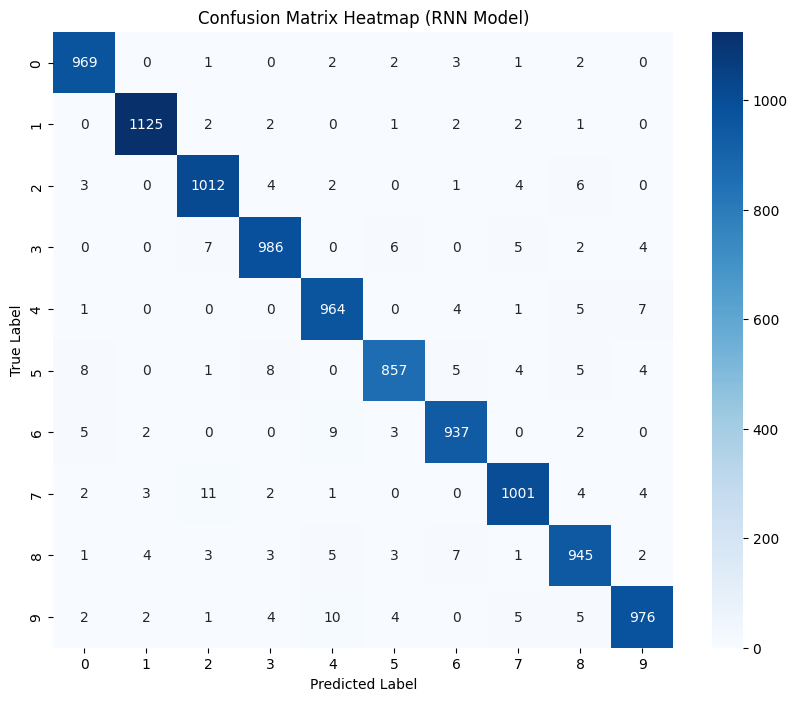

In [24]:
# 視覺化混淆矩陣
# 記得要先用 .asnumpy() 將矩陣從 GPU 移回 CPU 給 Matplotlib 處理
confusion_matrix_np = cp.asnumpy(confusion_matrix_cp)

plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_matrix_np,
    annot=True,      # 在格子中顯示數字
    fmt="d",         # 將數字格式化為整數
    cmap="Blues",    # 使用藍色系的色盤
    xticklabels=range(num_classes),
    yticklabels=range(num_classes),
)
plt.title("Confusion Matrix Heatmap (RNN Model)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Step 4-2: 計算 Precision 與 Recall

In [25]:
for i in range(num_classes):
    true_positives = confusion_matrix_cp[i, i]
    # 該 Col 的總和 (所有被預測為 i 的)
    predicted_positives = cp.sum(confusion_matrix_cp[:, i])
    # 該 Row 的總和 (所有實際上是 i 的)
    actual_positives = cp.sum(confusion_matrix_cp[i, :])

    # 計算 Precision 和 Recall，加上 1e-9 避免除以零
    precision = true_positives / (predicted_positives + 1e-9)
    recall = true_positives / (actual_positives + 1e-9)

    print(f"數字 '{i}':")
    # 使用 .asnumpy() 以便格式化輸出
    print(f"  精確率 (Precision): {cp.asnumpy(precision):.4f}")
    print(f"  召回率 (Recall):    {cp.asnumpy(recall):.4f}")

數字 '0':
  精確率 (Precision): 0.9778
  召回率 (Recall):    0.9888
數字 '1':
  精確率 (Precision): 0.9903
  召回率 (Recall):    0.9912
數字 '2':
  精確率 (Precision): 0.9750
  召回率 (Recall):    0.9806
數字 '3':
  精確率 (Precision): 0.9772
  召回率 (Recall):    0.9762
數字 '4':
  精確率 (Precision): 0.9708
  召回率 (Recall):    0.9817
數字 '5':
  精確率 (Precision): 0.9783
  召回率 (Recall):    0.9608
數字 '6':
  精確率 (Precision): 0.9771
  召回率 (Recall):    0.9781
數字 '7':
  精確率 (Precision): 0.9775
  召回率 (Recall):    0.9737
數字 '8':
  精確率 (Precision): 0.9672
  召回率 (Recall):    0.9702
數字 '9':
  精確率 (Precision): 0.9789
  召回率 (Recall):    0.9673


## Step 4-3: 繪制學習曲線

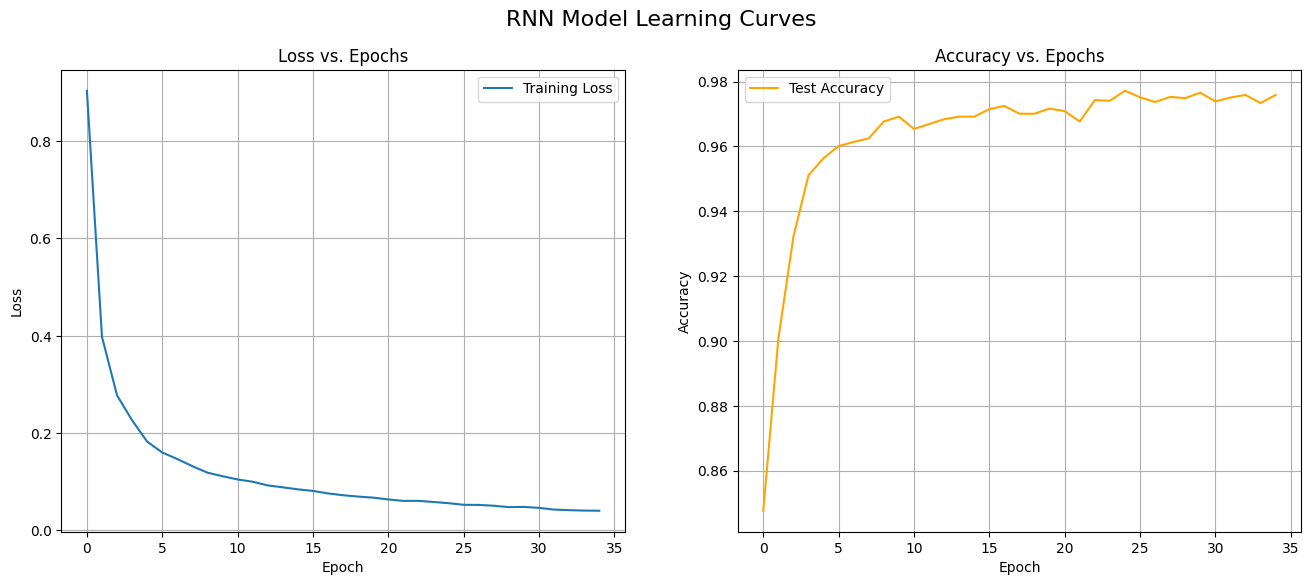

In [26]:
# 將 Cupy 陣列轉為 NumPy 陣列以便繪圖

# 1. 從 history 中取出資料
costs_cp = cp.array(history['costs'])
accuracies_cp = cp.array(history['accuracies'])

# 2. 使用 asnumpy() 轉換
costs_np = cp.asnumpy(costs_cp)
accuracies_np = cp.asnumpy(accuracies_cp)


# 開始繪圖
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('RNN Model Learning Curves', fontsize=16)

# 圖一：損失 (Loss) vs. Epochs
ax1.plot(costs_np, label='Training Loss')
ax1.set_title("Loss vs. Epochs")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)
ax1.legend()

# 圖二：準確率 (Accuracy) vs. Epochs
ax2.plot(accuracies_np, label='Test Accuracy', color='orange')
ax2.set_title("Accuracy vs. Epochs")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.grid(True)
ax2.legend()

plt.show()

# Bonus: CIFAR-10

## Bonus Step 1: 環境清理與準備

由於 CIFAR-10 的資料量比 MNIST 大，為了避免在 GPU 上出現記憶體不足 (Out of Memory) 的錯誤，我們先將記憶體中不再需要的 MNIST 相關變數清除。

In [27]:
import gc # 引入垃圾回收模組

# 定義要刪除的 MNIST 變數列表
vars_to_delete = [
    'train_x', 'train_y', 'train_y_cp_orig',
    'test_x', 'test_y', 'test_y_cp_orig',
    'trained_parameters', 'history',
    'test_predictions', 'confusion_matrix_cp'
]

# 遍歷列表，從全域變數中刪除
for var_name in vars_to_delete:
    if var_name in globals():
        del globals()[var_name]
        print(f"變數 '{var_name}' 已刪除。")

# 強制進行垃圾回收
gc.collect()

# 清空 CuPy 的記憶體池 (非常重要的一步)
mempool = cp.get_default_memory_pool()
mempool.free_all_blocks()

print("\nCupy 記憶體池已清空。")

變數 'train_x' 已刪除。
變數 'train_y' 已刪除。
變數 'train_y_cp_orig' 已刪除。
變數 'test_x' 已刪除。
變數 'test_y' 已刪除。
變數 'test_y_cp_orig' 已刪除。
變數 'trained_parameters' 已刪除。
變數 'history' 已刪除。
變數 'test_predictions' 已刪除。
變數 'confusion_matrix_cp' 已刪除。

Cupy 記憶體池已清空。


## Bonus Step 2: 下載並載入 CIFAR-10

與 HW4 做法類似

In [28]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xzf cifar-10-python.tar.gz

--2025-06-21 19:57:54--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  33.2MB/s    in 4.7s    

2025-06-21 19:57:59 (34.4 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [29]:
import pickle

def load_cifar10(root_path):
    # 內部函式，用於載入單一 batch 檔案
    def load_batch(filename):
        with open(os.path.join(root_path, filename), 'rb') as f:
            # 使用 latin1 編碼來讀取 Python 2 生成的 pickle 檔案
            datadict = pickle.load(f, encoding='latin1')
            X = datadict['data']
            Y = datadict['labels']
            # 將資料塑形為 (樣本數, 色彩頻道, 高度, 寬度)
            # 原始資料格式為 (N, 3072)，其中 3072 = 3 * 32 * 32
            # 儲存順序是 RRR...GGG...BBB...
            X = X.reshape(10000, 3, 32, 32)
            Y = np.array(Y)
            return X, Y

    # 載入並合併訓練資料 (共 5 個 batch)
    xs, ys = [], []
    for i in range(1, 6):
        x_batch, y_batch = load_batch(f"data_batch_{i}")
        xs.append(x_batch)
        ys.append(y_batch)
    train_x_np = np.concatenate(xs)
    train_y_np = np.concatenate(ys)

    # 載入測試資料
    test_x_np, test_y_np = load_batch("test_batch")

    # 載入類別名稱
    with open(os.path.join(root_path, 'batches.meta'), 'rb') as f:
        meta = pickle.load(f, encoding='latin1')
        class_names = meta['label_names']

    return train_x_np, train_y_np, test_x_np, test_y_np, class_names

In [30]:
# 執行載入
cifar10_train_x_np, cifar10_train_y_np, cifar10_test_x_np, cifar10_test_y_np, cifar10_class_names = load_cifar10("cifar-10-batches-py")

print("\n--- CIFAR-10 資料維度 (NumPy) ---")
print("訓練資料 X:", cifar10_train_x_np.shape)
print("訓練標籤 Y:", cifar10_train_y_np.shape)
print("測試資料 X:", cifar10_test_x_np.shape)
print("測試標籤 Y:", cifar10_test_y_np.shape)
print("類別名稱:", cifar10_class_names)


--- CIFAR-10 資料維度 (NumPy) ---
訓練資料 X: (50000, 3, 32, 32)
訓練標籤 Y: (50000,)
測試資料 X: (10000, 3, 32, 32)
測試標籤 Y: (10000,)
類別名稱: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Bonus Step 3: 資料預處理

In [31]:
# --- 1. 轉置與塑形 ---
# (N, C, H, W) -> (N, H, W, C)
train_x_transposed = cifar10_train_x_np.transpose(0, 2, 3, 1)
test_x_transposed = cifar10_test_x_np.transpose(0, 2, 3, 1)

# (N, H, W, C) -> (N, T_x, n_x)  (T_x=H, n_x=W*C)
cifar10_train_x_seq = train_x_transposed.reshape(50000, 32, -1)
cifar10_test_x_seq = test_x_transposed.reshape(10000, 32, -1)


# --- 2. 轉換為 Cupy 陣列並 Normalize ---
train_x = cp.asarray(cifar10_train_x_seq) / 255.0
test_x = cp.asarray(cifar10_test_x_seq) / 255.0


# --- 3. 處理標籤 (Cupy + One-Hot) ---
train_y_cp_orig = cp.asarray(cifar10_train_y_np)
test_y_cp_orig = cp.asarray(cifar10_test_y_np)

num_classes_cifar10 = 10
train_y = one_hot_encode(train_y_cp_orig, num_classes_cifar10)
test_y = one_hot_encode(test_y_cp_orig, num_classes_cifar10)


# --- 4. 驗證最終維度 ---
print("\n--- CIFAR-10 序列資料維度 (CuPy) ---")
print("train_x shape:", train_x.shape)
print("train_y shape:", train_y.shape)
print("test_x shape:", test_x.shape)
print("test_y shape:", test_y.shape)


--- CIFAR-10 序列資料維度 (CuPy) ---
train_x shape: (50000, 32, 96)
train_y shape: (50000, 10)
test_x shape: (10000, 32, 96)
test_y shape: (10000, 10)


## Bonus Step 4: 訓練 CIFAR-10 模型

In [34]:
# --- 設定 CIFAR-10 的 Hyperparameter ---
LEARNING_RATE_CIFAR = 0.01  # 稍微調低學習率
NUM_EPOCHS_CIFAR = 150     # 提高 Epoch 上限
BATCH_SIZE_CIFAR = 128
N_A_CIFAR = 256        # 增加隱藏層神經元數量
PATIENCE_CIFAR = 10      # 稍微增加耐心度

# --- 開始訓練！---
# 注意這裡的變數都是我們在 Bonus Step 3 中為 CIFAR-10 準備好的
cifar10_params, cifar10_history = rnn_model(
    train_x, train_y, train_y_cp_orig,
    test_x, test_y_cp_orig,
    n_a=N_A_CIFAR,
    learning_rate=LEARNING_RATE_CIFAR,
    num_epochs=NUM_EPOCHS_CIFAR,
    batch_size=BATCH_SIZE_CIFAR,
    use_early_stopping=True,
    early_stopping_patience=PATIENCE_CIFAR
)

# --- 儲存訓練好的 CIFAR-10 模型權重 ---
save_parameters(cifar10_params, "my_cifar10_rnn_model.npz")

Epoch 1/150 - Cost: 2.113161 - Accuracy: 0.2941 - Time: 10.28s
  -> Accuracy improved to 0.2941! Saving model.
Epoch 2/150 - Cost: 1.911338 - Accuracy: 0.3048 - Time: 10.00s
  -> Accuracy improved to 0.3048! Saving model.
Epoch 3/150 - Cost: 1.827638 - Accuracy: 0.3359 - Time: 10.32s
  -> Accuracy improved to 0.3359! Saving model.
Epoch 4/150 - Cost: 1.772197 - Accuracy: 0.3622 - Time: 11.33s
  -> Accuracy improved to 0.3622! Saving model.
Epoch 5/150 - Cost: 1.727441 - Accuracy: 0.3817 - Time: 10.36s
  -> Accuracy improved to 0.3817! Saving model.
Epoch 6/150 - Cost: 1.691920 - Accuracy: 0.4063 - Time: 10.34s
  -> Accuracy improved to 0.4063! Saving model.
Epoch 7/150 - Cost: 1.661781 - Accuracy: 0.4050 - Time: 10.86s
  -> Accuracy did not improve for 1 epoch(s).
Epoch 8/150 - Cost: 1.633048 - Accuracy: 0.4276 - Time: 10.34s
  -> Accuracy improved to 0.4276! Saving model.
Epoch 9/150 - Cost: 1.611042 - Accuracy: 0.4228 - Time: 10.90s
  -> Accuracy did not improve for 1 epoch(s).
Epoch

## Bonus Step 5: CIFAR-10 效能評估

In [ ]:
# 重新載入 CIFAR-10 模型 (如果需要)
cifar10_trained_parameters = load_parameters("my_cifar10_rnn_model.npz")

在 CIFAR-10 測試集上進行最終預測...
CIFAR-10 模型最終準確率: 52.79%


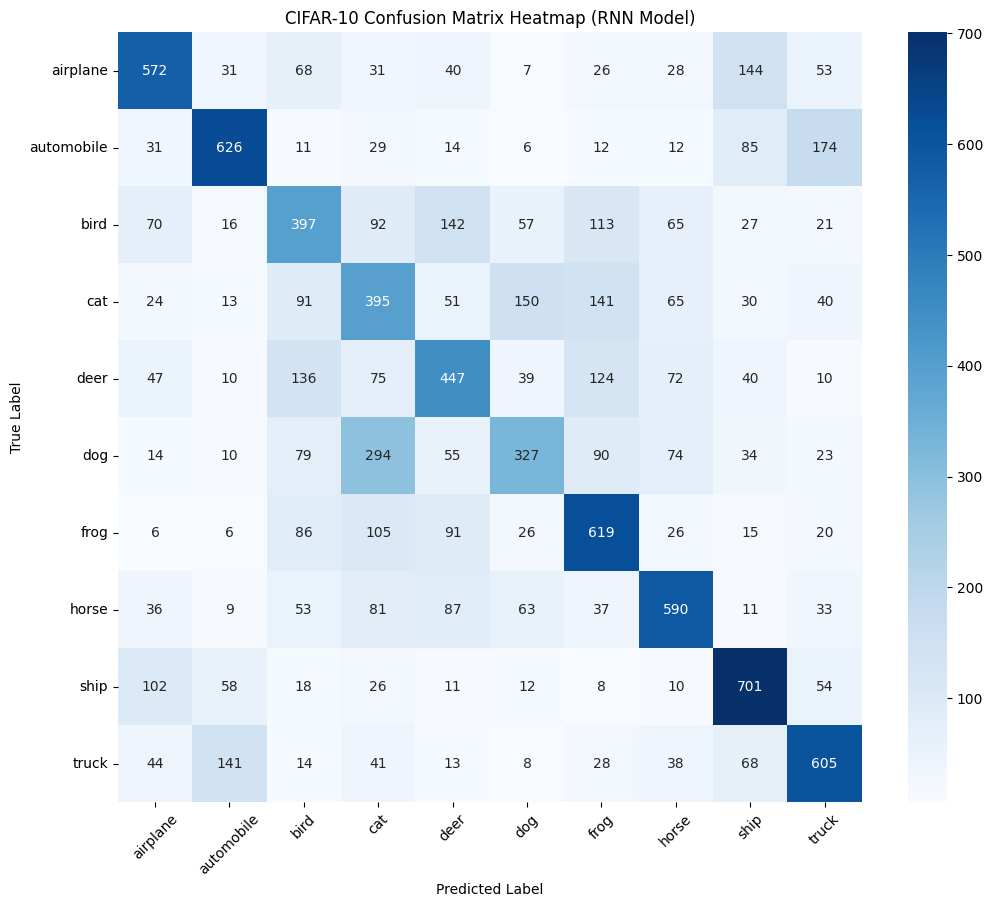

In [36]:
# 1. 在 CIFAR-10 測試集上進行最終預測
print("在 CIFAR-10 測試集上進行最終預測...")
cifar10_test_predictions = predict_rnn(test_x, cifar10_params)

# 2. 確認最終準確率
final_accuracy_cifar10 = calculate_accuracy_rnn(cifar10_test_predictions, test_y_cp_orig)
print(f"CIFAR-10 模型最終準確率: {cp.asnumpy(final_accuracy_cifar10)*100:.2f}%")


# 3. 建立 CIFAR-10 混淆矩陣
confusion_matrix_cifar10_cp = cp.zeros((num_classes_cifar10, num_classes_cifar10), dtype=int)
for i in range(len(test_y_cp_orig)):
    true_label = test_y_cp_orig[i]
    predicted_label = cifar10_test_predictions[i]
    confusion_matrix_cifar10_cp[true_label, predicted_label] += 1

# 4. 視覺化混淆矩陣 (使用類別名稱)
confusion_matrix_cifar10_np = cp.asnumpy(confusion_matrix_cifar10_cp)

plt.figure(figsize=(12, 10))
sns.heatmap(
    confusion_matrix_cifar10_np,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=cifar10_class_names, # 使用我們載入的類別名稱
    yticklabels=cifar10_class_names,
)
plt.title("CIFAR-10 Confusion Matrix Heatmap (RNN Model)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [37]:
# 計算 CIFAR-10 各類別的性能指標
print("\n--- CIFAR-10 各類別的性能指標 ---")
for i in range(num_classes_cifar10):
    true_positives = confusion_matrix_cifar10_cp[i, i]
    predicted_positives = cp.sum(confusion_matrix_cifar10_cp[:, i])
    actual_positives = cp.sum(confusion_matrix_cifar10_cp[i, :])

    precision = true_positives / (predicted_positives + 1e-9)
    recall = true_positives / (actual_positives + 1e-9)

    print(f"類別 '{cifar10_class_names[i]}':")
    print(f"  精確率 (Precision): {cp.asnumpy(precision):.4f}")
    print(f"  召回率 (Recall):    {cp.asnumpy(recall):.4f}")


--- CIFAR-10 各類別的性能指標 ---
類別 'airplane':
  精確率 (Precision): 0.6047
  召回率 (Recall):    0.5720
類別 'automobile':
  精確率 (Precision): 0.6804
  召回率 (Recall):    0.6260
類別 'bird':
  精確率 (Precision): 0.4166
  召回率 (Recall):    0.3970
類別 'cat':
  精確率 (Precision): 0.3379
  召回率 (Recall):    0.3950
類別 'deer':
  精確率 (Precision): 0.4700
  召回率 (Recall):    0.4470
類別 'dog':
  精確率 (Precision): 0.4705
  召回率 (Recall):    0.3270
類別 'frog':
  精確率 (Precision): 0.5167
  召回率 (Recall):    0.6190
類別 'horse':
  精確率 (Precision): 0.6020
  召回率 (Recall):    0.5900
類別 'ship':
  精確率 (Precision): 0.6069
  召回率 (Recall):    0.7010
類別 'truck':
  精確率 (Precision): 0.5857
  召回率 (Recall):    0.6050


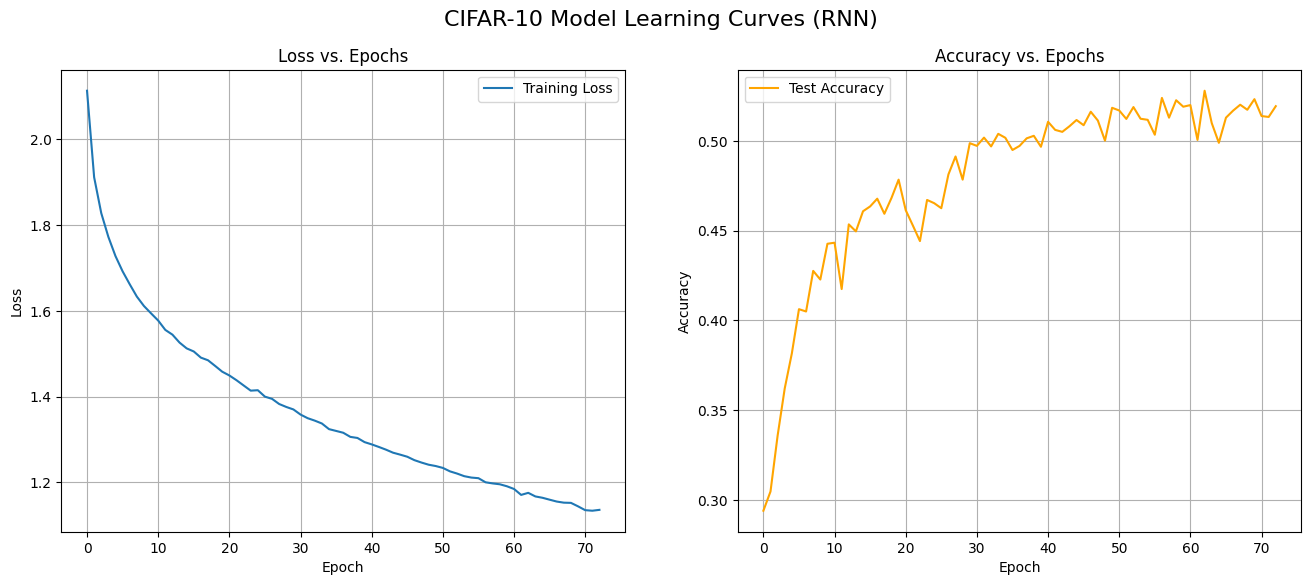

In [38]:
# --- 將 Cupy 陣列轉為 NumPy 陣列以便繪圖 ---
costs_cifar10_cp = cp.array(cifar10_history['costs'])
accuracies_cifar10_cp = cp.array(cifar10_history['accuracies'])
costs_cifar10_np = cp.asnumpy(costs_cifar10_cp)
accuracies_cifar10_np = cp.asnumpy(accuracies_cifar10_cp)

# --- 開始繪圖 ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('CIFAR-10 Model Learning Curves (RNN)', fontsize=16)

ax1.plot(costs_cifar10_np, label='Training Loss')
ax1.set_title("Loss vs. Epochs")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)
ax1.legend()

ax2.plot(accuracies_cifar10_np, label='Test Accuracy', color='orange')
ax2.set_title("Accuracy vs. Epochs")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.grid(True)
ax2.legend()

plt.show()

# Conclusion

本次作業成功地從零開始建構了一個功能完整的 RNN，不僅達成了作業要求，也完成了 CIFAR-10 的加分挑戰，從而驗證了對 RNN 核心概念，特別是 BPTT 演算法的理解。

在 MNIST 資料集上，模型表現出色，達到了 97.72% 的高準確率。從學習曲線圖中可以看到，訓練損失穩定下降，而測試準確率則快速上升後趨於平穩，顯示模型有效地學習到了手寫數字的序列特徵。混淆矩陣的結果也顯示，模型在大多數數字上都有很高的辨識度。透過解決初期的梯度消失問題，也讓我深刻體會到權重初始化對 RNN 訓練穩定性的重要性。

在 CIFAR-10 加分項目中，模型 52.79% 的準確率雖然遠低於其在 MNIST 上的成果，但這完全在預期之內。CIFAR-10 的自然影像是二維空間結構高度相關的資料，將其強行轉換為一維時間序列，本身就損失了大量的空間資訊（例如，一個物體的垂直與水平關聯性）。此外，Simple RNN 的「記憶」是短期的，對於長達 32 個 Timestep 且特徵維度高達 96 的序列，很難捕捉到圖像從頭到尾的完整語意。儘管準確率不高，但成功將模型拓展至處理更複雜、更高維度的序列資料，證明了模型架構的通用性。

與 CNN 的比較與反思：對比 HW4 的 CNN 模型 (MNIST 準確率 98.60%)，本次的 RNN 模型 (97.72%) 表現略遜一籌。這凸顯了不同網路架構的「歸納偏置 (Inductive Bias)」差異。CNN 的卷積核設計，使其天然具備 **空間局部性** 和 **平移不變性** 的特點，非常適合提取影像的空間特徵（如邊緣、紋理）。而 RNN 的設計則偏向於捕捉 **時間序列上的前後關聯性** 。將圖片視為像素列序列的作法，雖然捕捉了垂直方向的關聯，卻破壞了水平方向的空間結構，因此在影像分類這類空間任務上，其天生劣勢是難以避免的。

總體而言，本次專案最大的收穫在於透過親手打造 BPTT，深刻體會了梯度在時間維度上傳播的機制，以及它為何會產生梯度消失/爆炸等經典問題。這個經驗也讓我更清楚地認識到，針對不同的問題領域，選擇合適的模型架構是多麼至關重要。